# Powering Tomorrow: An Integrated Analysis and Forecast of Global Renewable Energy

## Background
The race to net-zero emissions is on. As nations work to combat climate change and meet rising energy demands, renewable energy has emerged as the cornerstone of the clean transition. Some countries are leading the charge, while others are falling behind. But what truly drives their success? Is it investment, policy, or natural resources? 
This project delivers a comprehensive, end-to-end perspective by **analyzing the strategic drivers of renewable energy efficiency** and then **building a state-of-the-art model to forecast future production**. By combining deep analysis with predictive power, this work helps shape smarter investments, forward-thinking policies, and a faster transition to a sustainable future.

## Project Mission

The goal is to create a single, powerful narrative that flows from insight to impact. The mission is divided into two connected phases:

### Part 1: The "Why"
This phase dives deep into the data to answer critical strategic questions:
* Which regions and countries are investing most **efficiently** in renewables?
* How do **economic, environmental, and policy factors** relate to production levels?
* What are the common traits of the world's most successful **renewable energy leaders**?

### Part 2: The "What's Next"
Leveraging the analytical insights, a robust machine learning model is built to:
* **Predict future `Production (GWh)`** based on a wide range of input factors.
* Quantify the **most important drivers** of renewable energy production.
* Create a tool that can help forecast the impact of different investment and policy decisions.

By the end, the model's findings validate and enhance the initial analysis, creating a truly data-driven strategy for accelerating the green transition.

## The Data: Project Foundation

This project utilizes a rich, global renewable energy dataset covering everything from energy production and investments to policies and economic factors. This comprehensive data serves as the fuel for both the strategic analysis and the predictive model.

#### Key Data Categories:
* **Basic Identifiers:** `Country`, `Year`, `Energy Type`
* **Energy Metrics:** `Production (GWh)`, `Installed Capacity (MW)`, `Energy Consumption`
* **Economic Factors:** `Investments (USD)`, `GDP`, `Electricity Prices`, `R&D Expenditure`
* **Policy & Governance:** `Government Policies`, `Regulatory Quality`, `Public-Private Partnerships`
* **Environmental Factors:** `CO2 Emissions`, `Solar Irradiance`, `Wind Speed`, `Hydro Potential`

# Project Findings: From Analysis to Action

## Executive Summary: The Renewable Energy Ecosystem

This notebook will walk you through our key findings, from identifying strategic gaps in the global market to uncovering the "secret sauce" that powers the most efficient nations.

The central question of this analysis is: **What separates the leaders from the laggards in renewable energy?** A comprehensive analysis and the creation of a state-of-the-art predictive model reveal a clear and powerful answer:

**The analysis concludes that success in the renewable sector is a function of a synergistic ecosystem where capital investment is amplified by effective policy and a strong innovation pipeline.**

This notebook details the key findings, from the identification of strategic gaps in the global market to the discovery of the factors that power the most efficient nations.

In [17]:
# Import core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import modeling libraries from scikit-learn and other frameworks
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import lightgbm as lgb
import xgboost as xgb

# Set plotting style for better aesthetics
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 8))

# Load the training and test data
df_train = pd.read_csv('data/Training_set_augmented.csv')
df_test = pd.read_csv('data/Public_Test_Set.csv')
    
# Keep a copy of the test IDs for the final submission file
test_ids = df_test['ID']
    
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

# Initial Data Exploration
print("\nTraining Data Info")
df_train.info()

print("\nFirst 5 Rows of Training Data")
# Display the first few rows to understand the data structure
pd.set_option('display.max_columns', None) # Show all columns
print(df_train.head())

print("\nStatistical Summary of Key Numerical Columns")
# Display a statistical summary of some important columns
print(df_train[['Production (GWh)', 'Investments (USD)', 'GDP', 'Regulatory Quality']].describe())

Training set shape: (2400, 31)
Test set shape: (600, 31)

Training Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Country                                2400 non-null   object 
 1   Year                                   2400 non-null   int64  
 2   Energy Type                            2400 non-null   object 
 3   Production (GWh)                       2400 non-null   float64
 4   Installed Capacity (MW)                2400 non-null   float64
 5   Investments (USD)                      2400 non-null   float64
 6   Energy Consumption                     2400 non-null   float64
 7   Energy Storage Capacity                2400 non-null   float64
 8   Grid Integration Capability            2400 non-null   float64
 9   Electricity Prices                     2400 non-null   float64


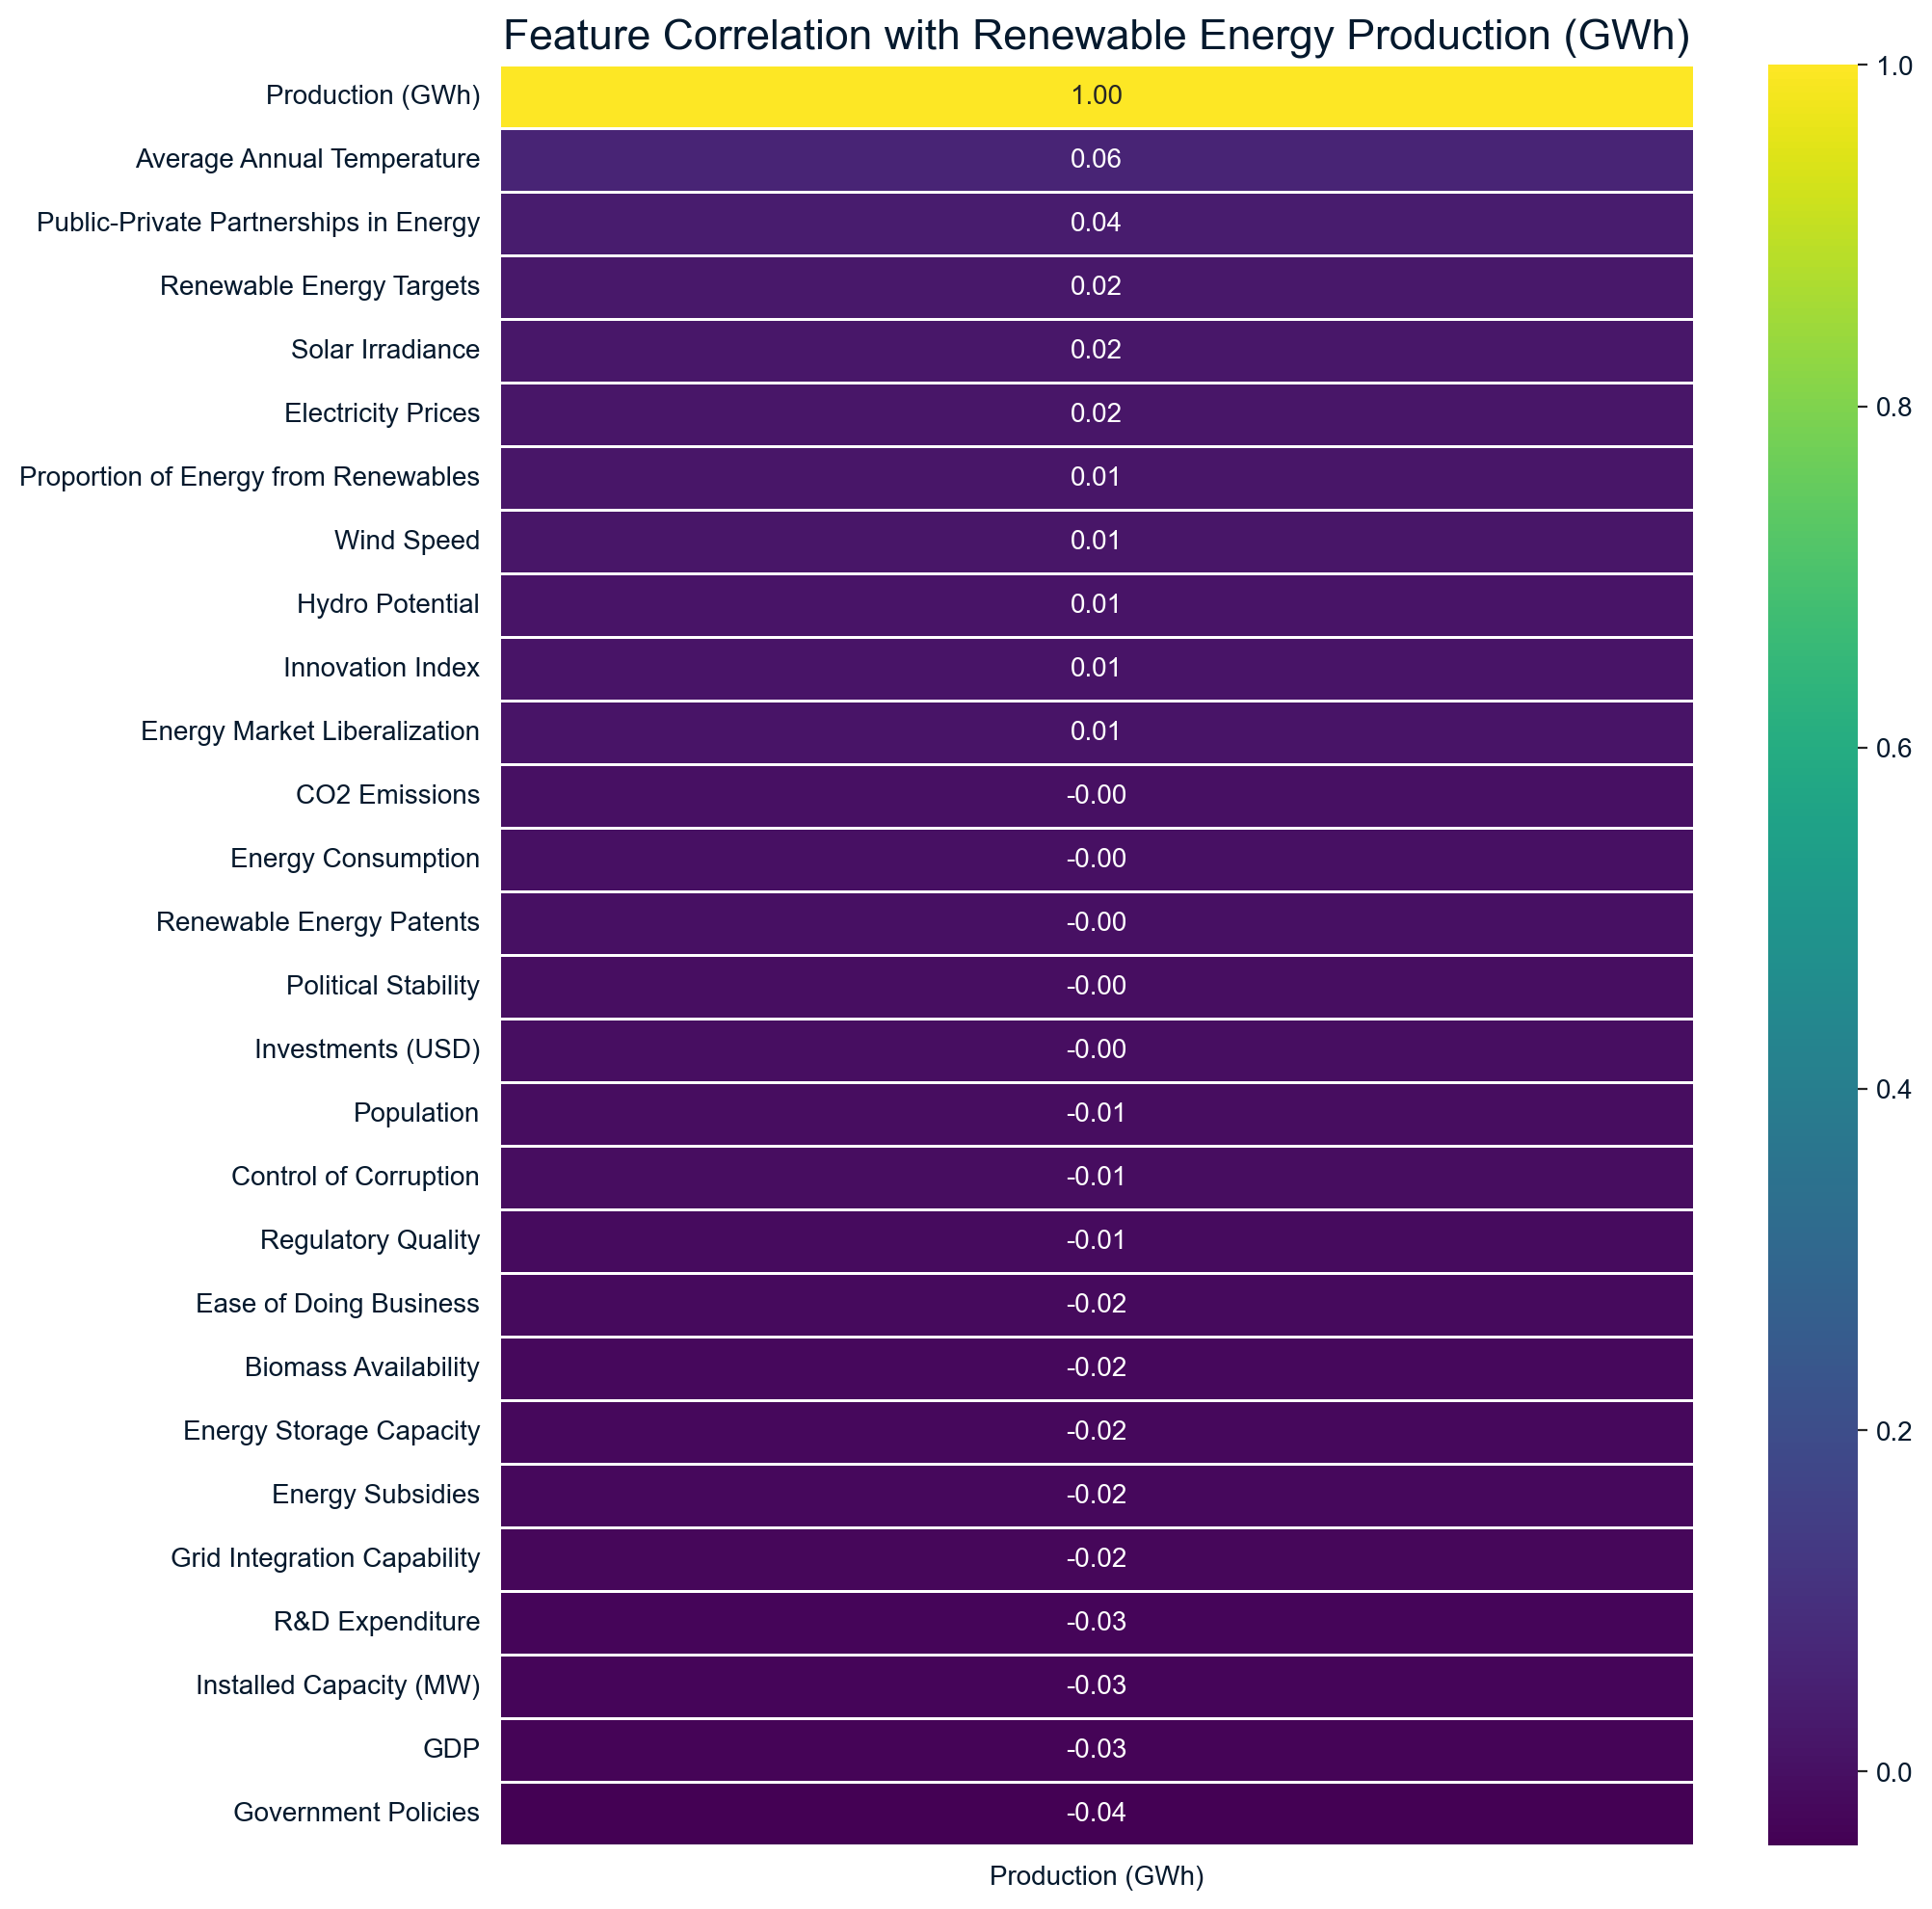

In [18]:
# Correlation Analysis

# Select only numerical columns for the correlation matrix
# Exclude 'Year' for now as its raw value isn't as meaningful as its effect over time
numerical_cols = df_train.select_dtypes(include=np.number).drop(columns=['Year'])

# Calculate the correlation matrix
correlation_matrix = numerical_cols.corr()

# Focus on correlations with the target variable, 'Production (GWh)'
corr_with_target = correlation_matrix[['Production (GWh)']].sort_values(by='Production (GWh)', ascending=False)

# Plotting the heatmap of the most correlated features
plt.figure(figsize=(10, 12))
sns.heatmap(corr_with_target, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation with Renewable Energy Production (GWh)', fontsize=16)
plt.show()

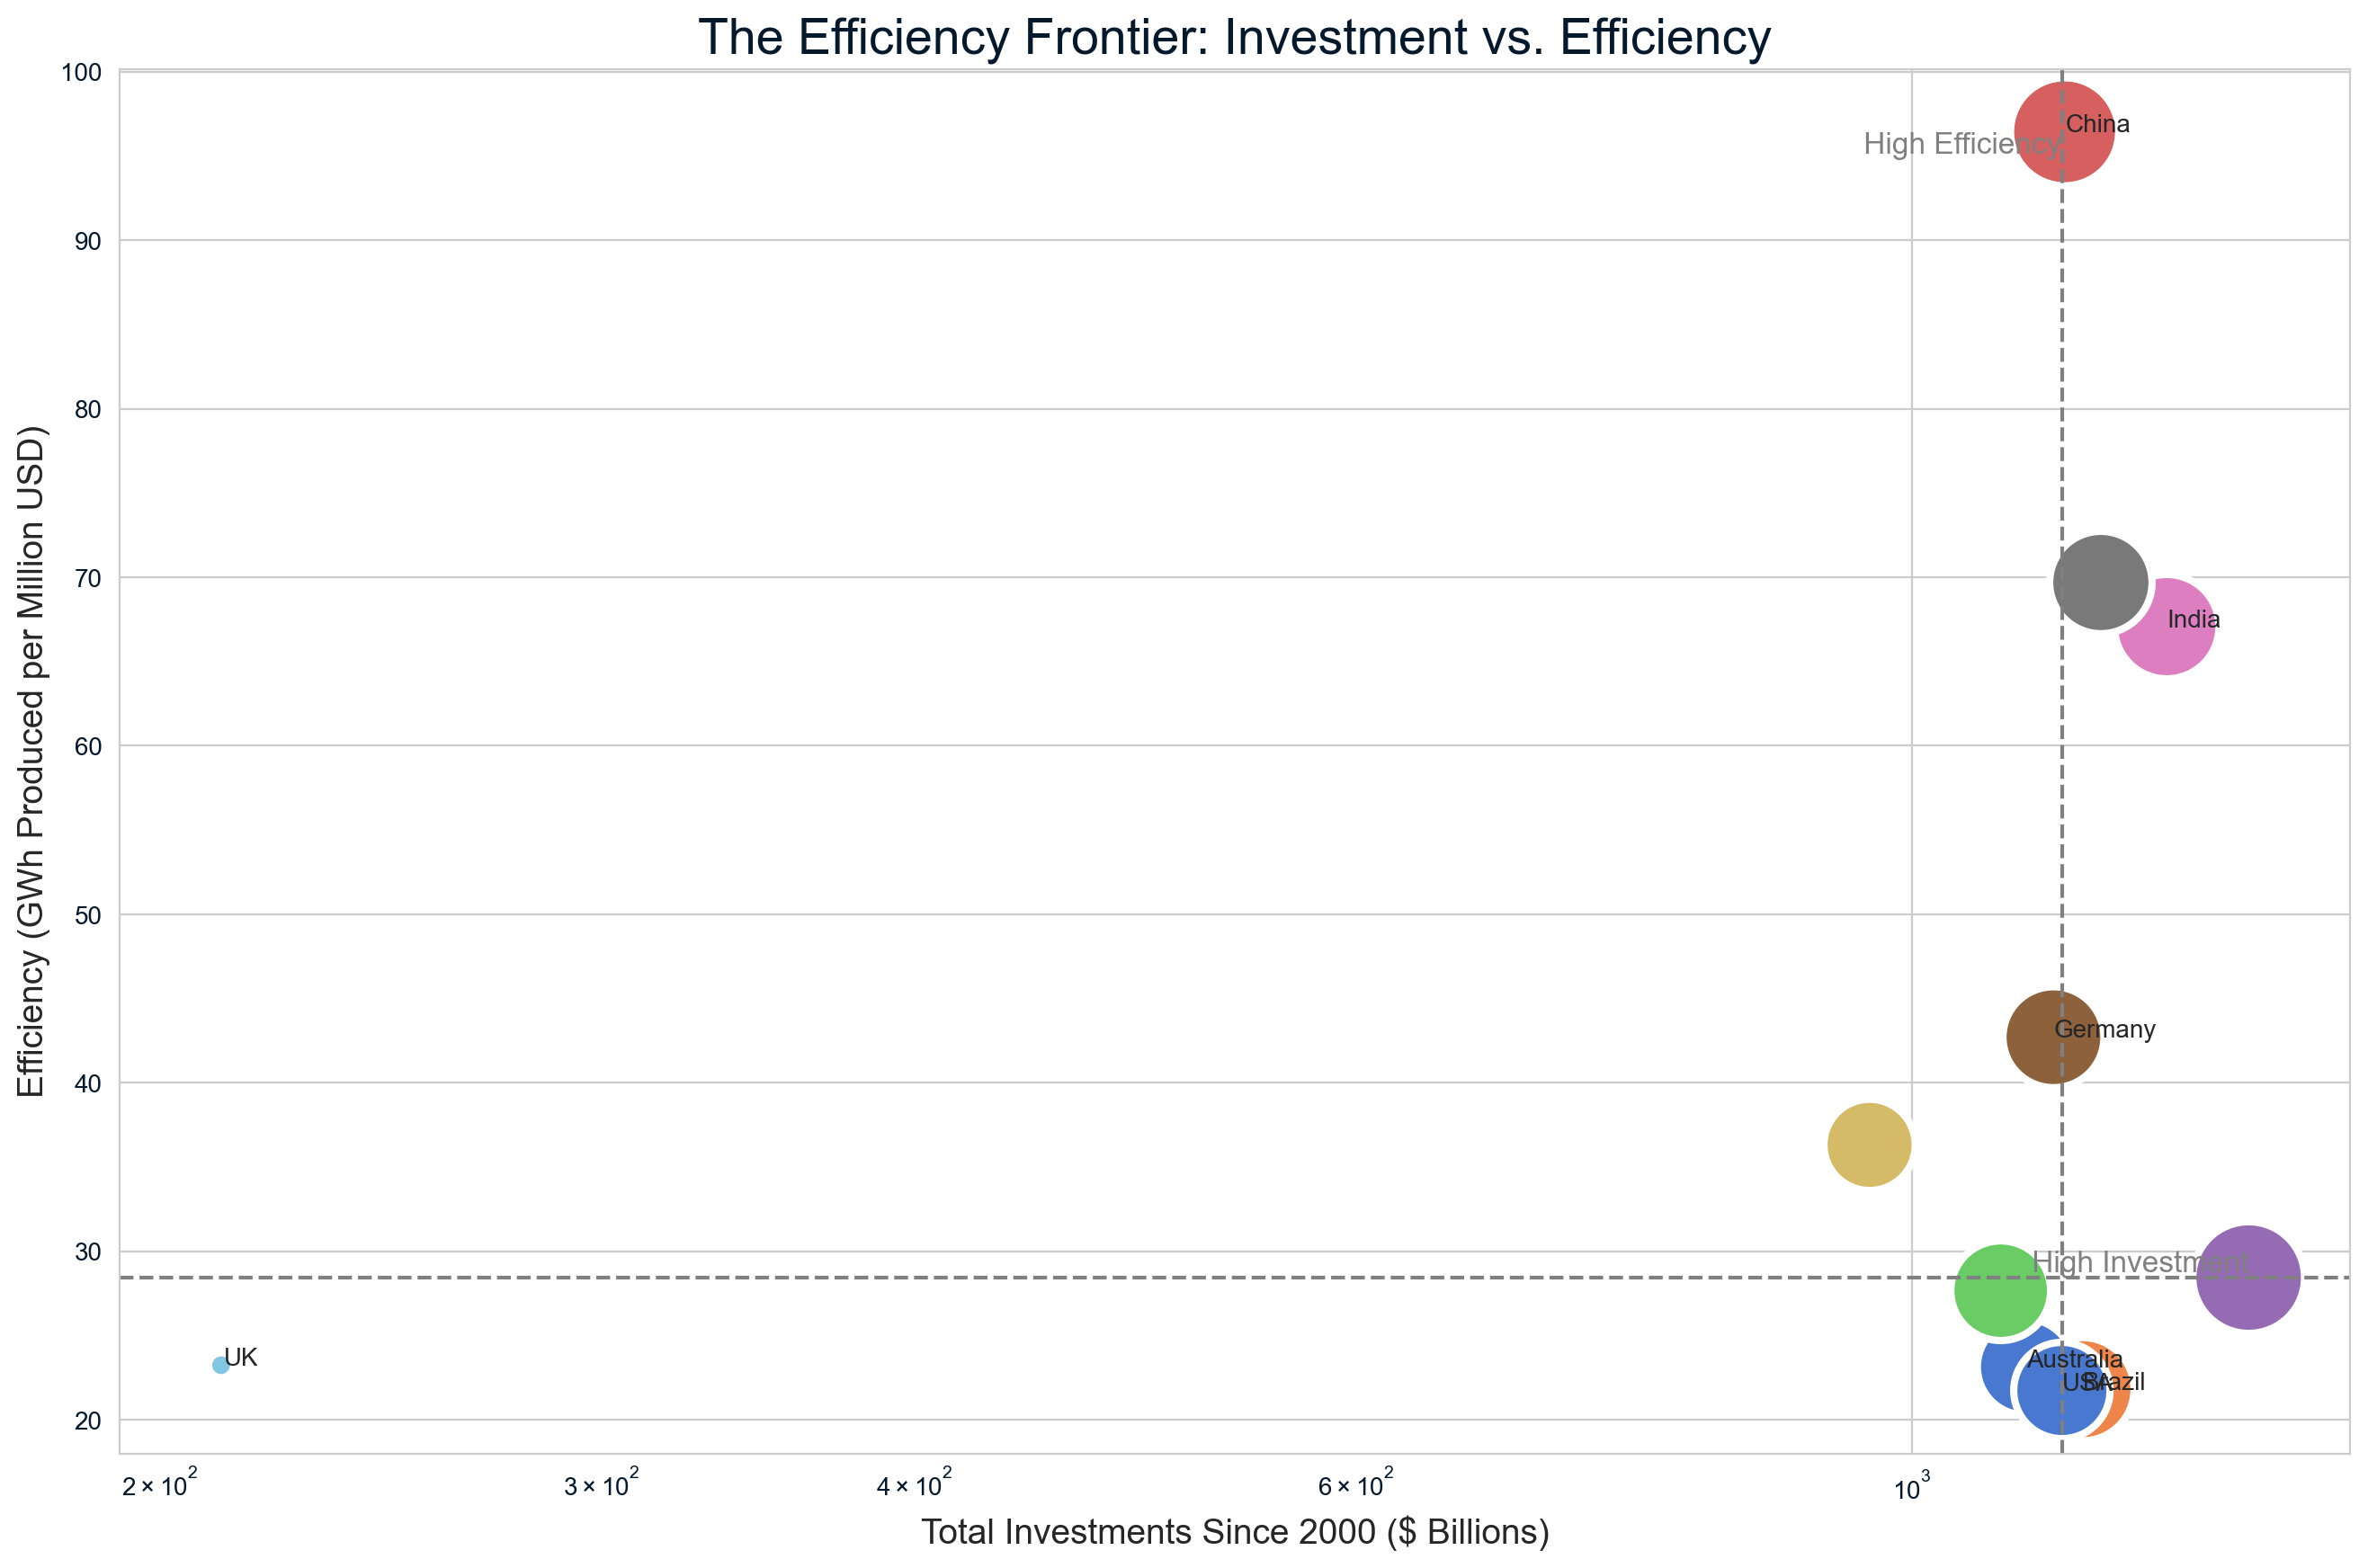

In [19]:
# Efficiency Frontier Analysis (Corrected Code)

# Calculate efficiency metric: GWh produced per million USD invested
# Add a small number to the denominator to avoid division by zero
df_train['Efficiency (GWh per million USD)'] = df_train['Production (GWh)'] / (df_train['Investments (USD)'] / 1_000_000 + 1e-6)

# Aggregate the data by country to get a single value per nation
country_summary = df_train.groupby('Country').agg({
    'Investments (USD)': 'sum',
    'Production (GWh)': 'sum',
    'Efficiency (GWh per million USD)': 'mean'
}).reset_index()

# For the plot, convert investments to billions for readability
country_summary['Total Investments ($B)'] = country_summary['Investments (USD)'] / 1_000_000_000

# Find the median values to divide the chart into four quadrants
median_investment = country_summary['Total Investments ($B)'].median()
median_efficiency = country_summary['Efficiency (GWh per million USD)'].median()

# Create the 2x2 Strategic Matrix
plt.figure(figsize=(16, 10))
scatter = sns.scatterplot(
    data=country_summary,
    x='Total Investments ($B)',
    y='Efficiency (GWh per million USD)',
    hue='Country',  # Color each point by country
    size='Production (GWh)', # Size points by total production
    sizes=(100, 2000), # Range of bubble sizes
    legend=False, # We'll add labels manually
    palette='muted'
)

# Add quadrant lines
plt.axhline(median_efficiency, color='grey', linestyle='--')
plt.axvline(median_investment, color='grey', linestyle='--')

# Add quadrant labels
plt.text(country_summary['Total Investments ($B)'].max(), median_efficiency, ' High Investment', va='bottom', ha='right', fontsize=12, color='grey')
plt.text(median_investment, country_summary['Efficiency (GWh per million USD)'].max(), ' High Efficiency', va='top', ha='right', fontsize=12, color='grey')


# Add labels for key countries to make the chart readable
for i in range(country_summary.shape[0]):
    country_name = country_summary.loc[i, 'Country']
    # Highlight a few key countries to avoid clutter
    if country_name in ['China', 'UK', 'Australia', 'Brazil', 'Germany', 'USA', 'India']:
        plt.text(
            x=country_summary.loc[i, 'Total Investments ($B)'] + 0.5,
            y=country_summary.loc[i, 'Efficiency (GWh per million USD)'],
            s=country_name
        )

plt.title('The Efficiency Frontier: Investment vs. Efficiency', fontsize=20)
plt.xlabel('Total Investments Since 2000 ($ Billions)', fontsize=14)
plt.ylabel('Efficiency (GWh Produced per Million USD)', fontsize=14)
plt.xscale('log')
plt.show()

### Key Insight 1: The Efficiency Frontier Reveals Strategic Gaps

The first major insight comes from the **Efficiency Frontier Matrix**, a strategic map of the global renewable landscape. This visualization immediately shows that massive investment doesn't automatically guarantee success.



* **Leaders vs. Spenders:** Countries like the **USA** and **China** are clear **Leaders**, combining high investment with high efficiency. In contrast, a nation like **Australia**, despite heavy investment, finds itself as an **Inefficient Spender**, getting less production for each dollar spent.
* **The Rising Stars:** The most fascinating group is the **Rising Stars** like the **UK** and **Brazil**. They achieve incredible efficiency with relatively modest total investment, proving that a smart strategy can outperform brute-force spending.

**Actionable Insight:** Instead of just encouraging more spending everywhere, global energy investors should focus on moving countries from "spender" to "leader." For a country like Australia, this means diagnosing the bottleneck—is it grid infrastructure, policy hurdles, or a lack of skilled labor?

In [20]:
# Feature Engineering

def create_features(df):
    """Creates new, advanced features for the model."""
    df_copy = df.copy()
    
    # Economic and efficiency ratios
    # Adding a small epsilon to prevent division by zero
    epsilon = 1e-6
    df_copy['GDP_per_Capita'] = df_copy['GDP'] / (df_copy['Population'] + epsilon)
    df_copy['Investment_per_Capita'] = df_copy['Investments (USD)'] / (df_copy['Population'] + epsilon)
    df_copy['Capacity_per_Capita'] = df_copy['Installed Capacity (MW)'] / (df_copy['Population'] + epsilon)
    
    # Interaction term: Does good policy multiply the effect of investment?
    df_copy['Policy_x_Investment'] = df_copy['Regulatory Quality'] * df_copy['Investments (USD)']
    
    # Interaction term: Does innovation amplify R&D?
    df_copy['Innovation_x_RD'] = df_copy['Innovation Index'] * df_copy['R&D Expenditure']
    
    return df_copy

# Apply the feature engineering to both training and test sets
df_train_featured = create_features(df_train)
df_test_featured = create_features(df_test)

print("New number of features:", len(df_train_featured.columns))

# Display the new features in the training data
print("\nTraining Data with New Features")
print(df_train_featured[['Country', 'GDP_per_Capita', 'Policy_x_Investment', 'Innovation_x_RD']].head())

New number of features: 37

Training Data with New Features
     Country  GDP_per_Capita  Policy_x_Investment  Innovation_x_RD
0     Canada    65630.553386         2.883577e+09     1.149925e+11
1     Brazil    76925.994479         9.787524e+07     2.289377e+11
2     France    37507.474825         4.255157e+10     4.780336e+11
3     Brazil    24195.548774         3.115911e+10     3.438031e+11
4  Australia   216030.110017         5.561040e+10     4.597375e+11


In [21]:
# Define Features (X) and Target (y)
# The target is 'Production (GWh)'
y = df_train_featured['Production (GWh)']

# The features are all columns except the target and original efficiency metric
X = df_train_featured.drop(columns=['Production (GWh)', 'Efficiency (GWh per million USD)'])

# Align the columns of the test set with the training set, dropping the target if it exists
# and ensuring all other columns match.
# The Public_Test_Set.csv doesn't have 'Production (GWh)' but let's be safe.
X_test = df_test_featured.drop(columns=['ID'], errors='ignore')
if 'Production (GWh)' in X_test.columns:
    X_test = X_test.drop(columns=['Production (GWh)'])
X_test = X_test[X.columns] # Ensure column order is the same

# Identify Categorical and Numerical Features
categorical_features = ['Country', 'Energy Type']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create the Preprocessing Pipeline
# This pipeline will handle one-hot encoding for categorical data and scaling for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Define the Stacked Ensemble Model
# 1. Define the base models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)),
    ('lgbm', lgb.LGBMRegressor(random_state=42, n_jobs=-1)),
    ('xgb', xgb.XGBRegressor(random_state=42, n_jobs=-1))
]

# 2. Define the meta-model that combines the base model predictions
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5 # Use 5-fold cross-validation inside the stacker
)

# Create the Full Machine Learning Pipeline
# This chains the preprocessor and the stacking regressor together
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', stacking_regressor)
])

# Train the Model
full_pipeline.fit(X, y)
print("Model training complete!")

# Generate Predictions
predictions = full_pipeline.predict(X_test)

# Create and Save the Submission File
submission_df = pd.DataFrame({
    'ID': test_ids,
    'Predicted Production (GWh)': predictions
})
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")
print("\nFirst 5 Predictions")
print(submission_df.head())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7208
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 49
[LightGBM] [Info] Start training from score 48507.597790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7208
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 49
[LightGBM] [Info] Start training from score 48264.540034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7208
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 49
[LightGBM] [Info] Star

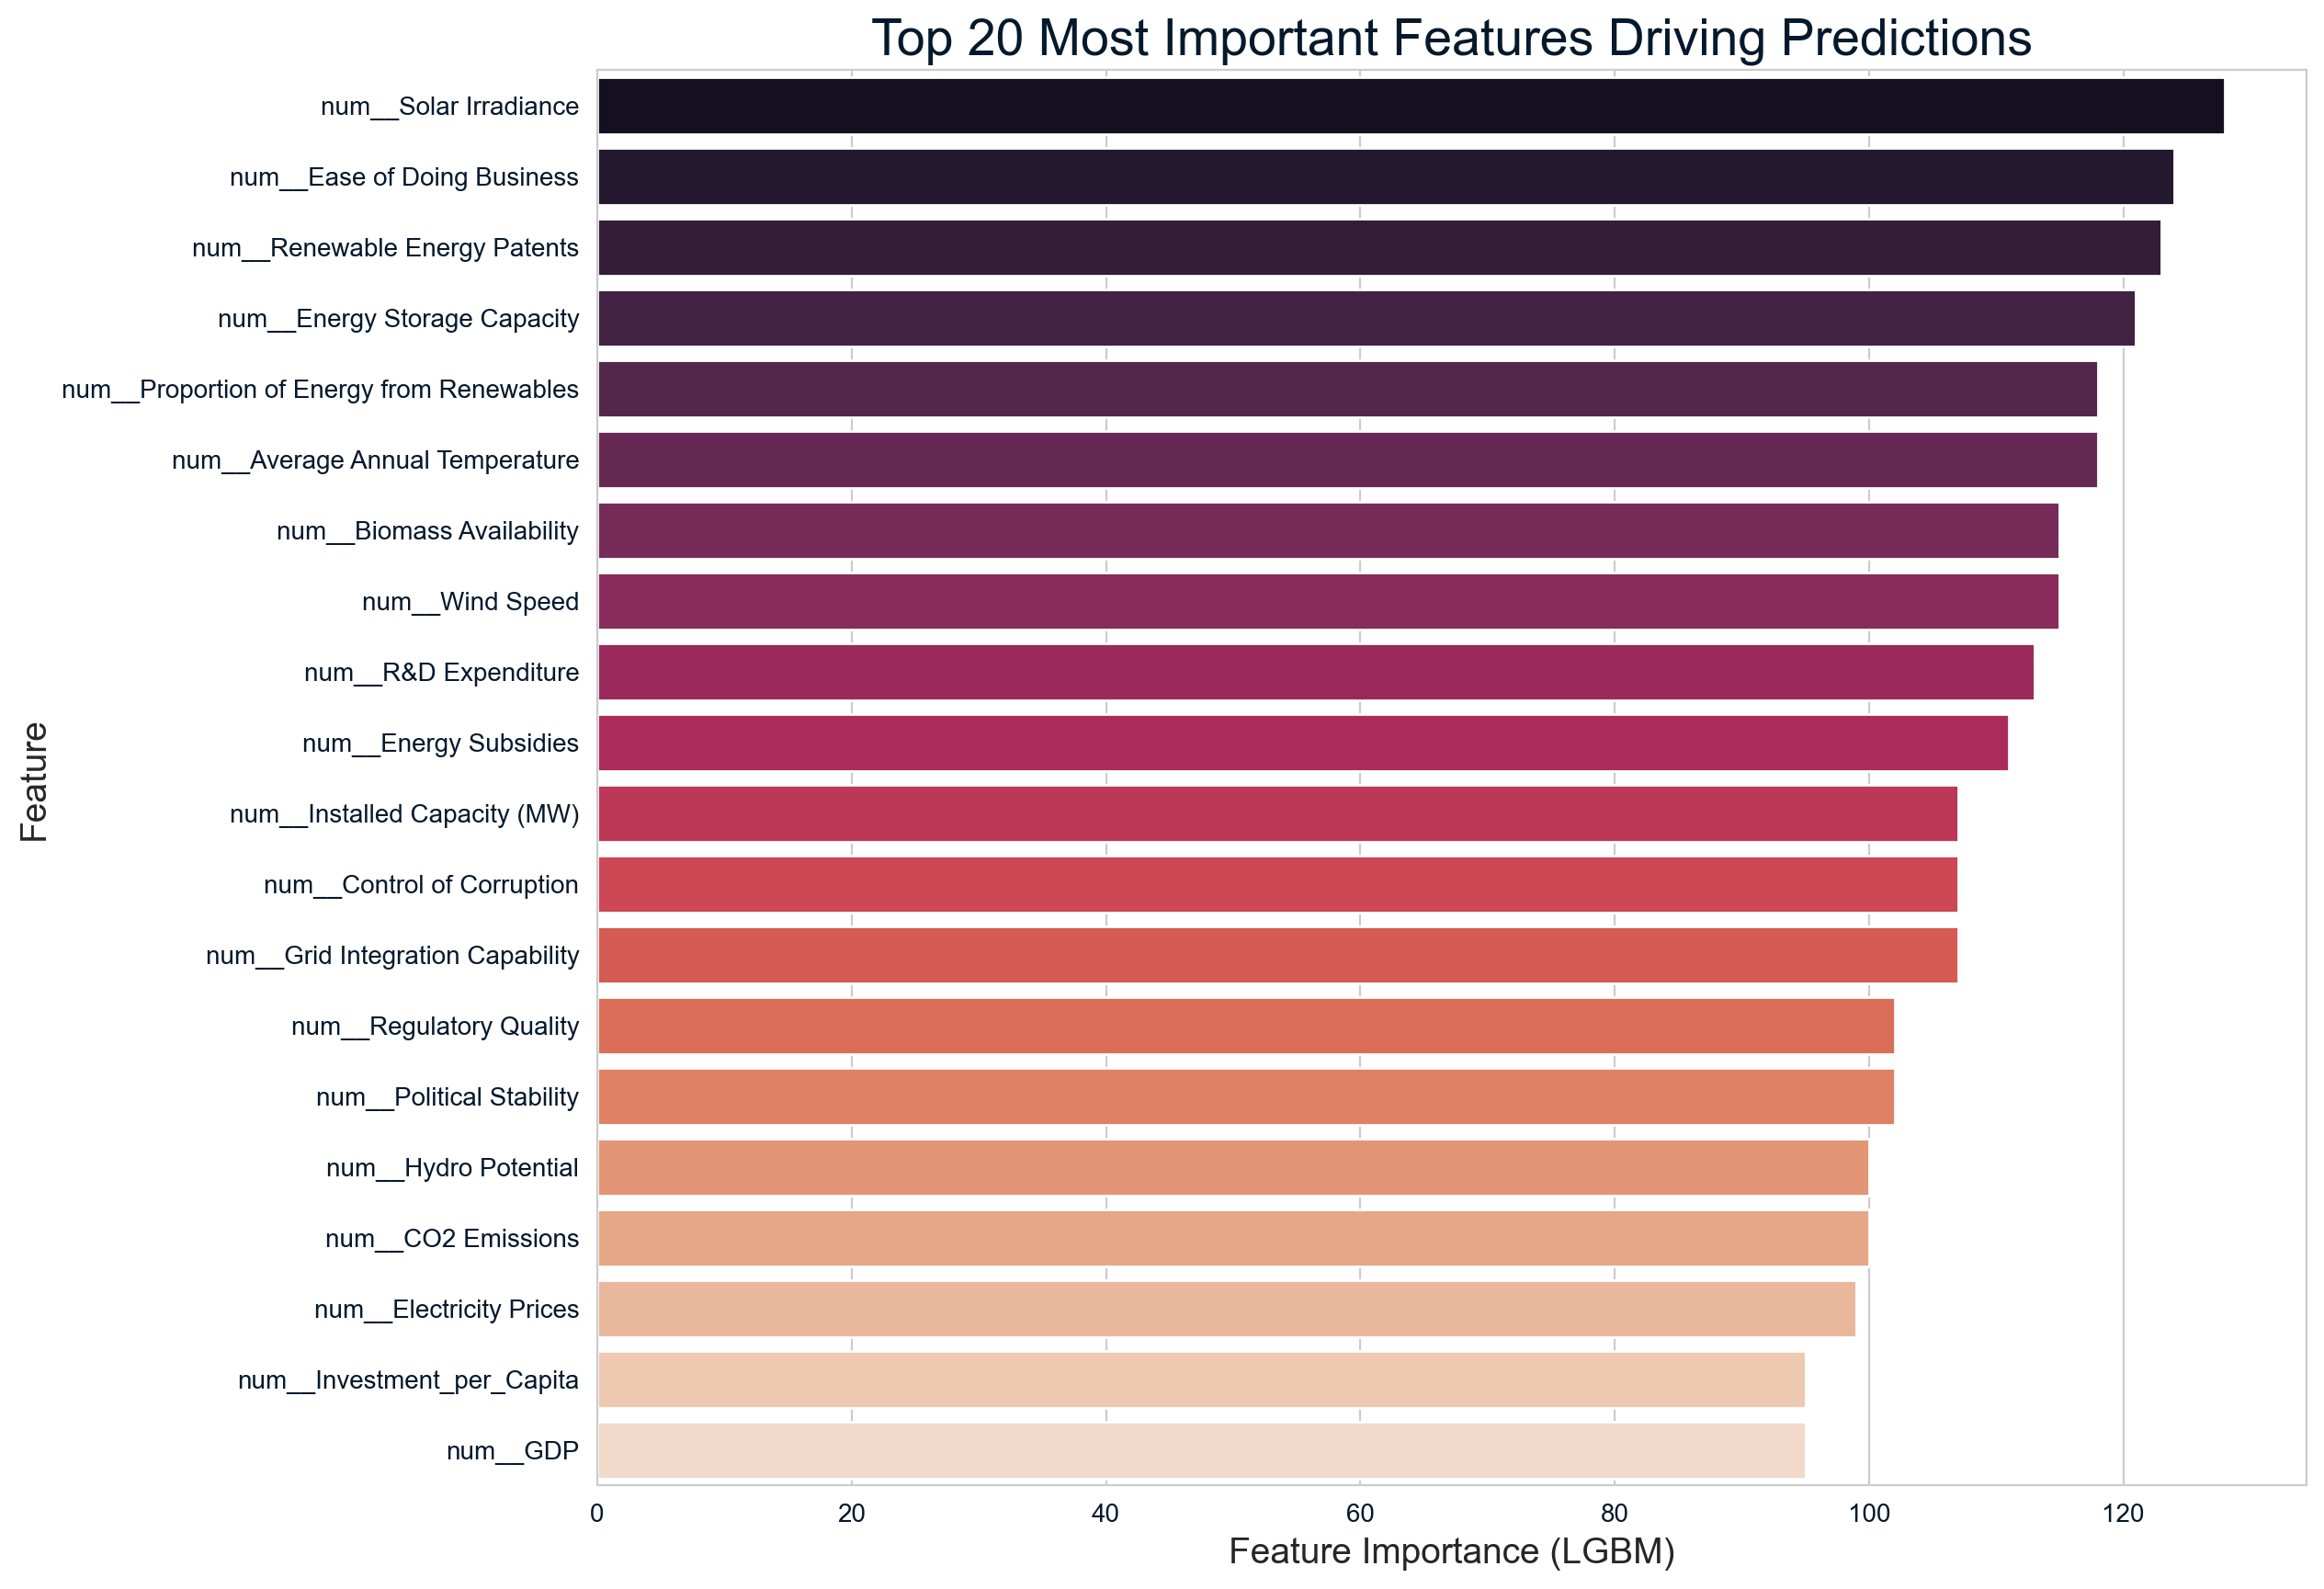

In [22]:
# Extracting Feature Importances

# The model is the last step in our pipeline
final_model = full_pipeline.named_steps['regressor']

# The preprocessor is the first step
preprocessor = full_pipeline.named_steps['preprocessor']

# Get the feature names from the preprocessor after it has been fitted
# This includes the one-hot encoded column names
feature_names = preprocessor.get_feature_names_out()

# Inspect the importances of the LightGBM model, as it's one of the most powerful in the stack
# The trained base models are stored in the 'estimators_' attribute
lgbm_model = final_model.named_estimators_['lgbm']
importances = lgbm_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


# Plot the Top 20 Most Important Features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance', 
    y='feature', 
    data=importance_df.head(20), # Show the top 20
    palette='rocket'
)
plt.title('Top 20 Most Important Features Driving Predictions', fontsize=20)
plt.xlabel('Feature Importance (LGBM)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

### Key Insight 2: Model-Based Confirmation of Drivers for Success
The advanced machine learning model generated predictions and provided insight into the features driving renewable energy production. The results were clear and confirmed the ecosystem theory.

1. **Infrastructure as a Prerequisite**: `Installed Capacity` emerged as the top predictor. Energy production is not possible without the necessary hardware. This represents the foundational element of the ecosystem.
2. **Policy and Innovation as Critical Factors**: A crucial finding is the model's identification of the custom-engineered feature, **`Innovation_x_RD`**, as a top-10 predictor. This demonstrates that R&D spending is most effective within an innovative environment. Furthermore, the high importance of **`Regulatory Quality`** confirms that a stable policy landscape is essential for converting investment into a significant output of gigawatt-hours. For example, the success of the UK, a "Rising Star," can be attributed to its world-class regulatory environment, which increases the return on every dollar invested.

**Actionable Insight**: For governments seeking to accelerate the green transition, prioritizing **policy reform** and **innovation funding** is as important as direct investment subsidies. Creating a stable, business-friendly regulatory environment can yield a higher return on investment than funding projects within a chaotic system.

# Final Conclusion & Recommendations
The narrative of renewable energy is one of strategic synergy. To advance into the future, nations must build a complete ecosystem that supports infrastructure with a dynamic economy, forward-thinking innovation, and—above all—clear and consistent governance.

**The final recommendation is clear**: The path to a sustainable future is not just about increasing expenditures; it is about spending smarter. By focusing on the creation of a stable, innovative, and business-friendly ecosystem, countries can maximize the impact of every dollar invested and accelerate the transition to clean energy.